# BACKTEST EventDriven

In [263]:
%matplotlib inline  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from data_source.alpha_vantage_download import AlphaVantageDownload as Downloader# out custom function to download data
import tpot # for machine learning pipeline
import datetime
from data_source.resolution import Resolution
import os
import sklearn

### Configure Backtest

In [264]:
SYMBOL = 'BBVA.MC'
START_BACKTEST = datetime.datetime(2017, 1, 1)
RESOLUTION = Resolution.one_day
CAPITAL=1000
LOOKBACK_BARS=5
OPEN_TO_CLOSE = False
CHEAT_TRAIN=False

### Download Data

In [265]:
startSTR = datetime.datetime.strftime(START_BACKTEST,'%Y%m%d')
tempFile = '%s_%s_%s.csv'%(SYMBOL,startSTR,RESOLUTION)
if not os.path.exists(tempFile):
    data = Downloader().download(symbol='BBVA.MC',start=datetime.datetime(2017, 1, 1),resolution=Resolution.one_day)
    data.to_csv(tempFile)
else:
    data = pd.DataFrame.from_csv(tempFile)

In [266]:
data.head()

,symbol,open,high,low,close,volume
index,,,,,,
2017-01-02,BBVA.MC,6.459,6.474,6.374,6.0952,19607737.0
2017-01-03,BBVA.MC,6.480,6.686,6.452,6.2135,160332414.0
2017-01-04,BBVA.MC,6.585,6.601,6.434,6.1472,179333129.0
2017-01-05,BBVA.MC,6.463,6.554,6.437,6.1690,144550880.0
2017-01-06,BBVA.MC,6.530,6.578,6.454,6.2144,113930823.0


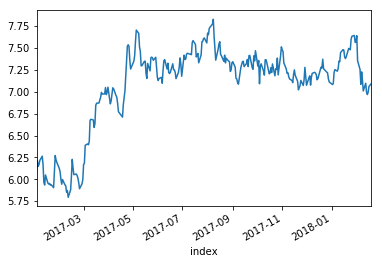

In [268]:
data['close'].plot()

In [270]:
shares = int(CAPITAL/data['close'][0])
print('Going to buy %i shares when predicted'%shares)

Going to buy 164 shares when predicted


### Machine learning training

In [271]:
def getReturnOfTrade(dataframe):
    data_position_result = data_position.copy()
    if OPEN_TO_CLOSE:
        data_position_result['returns'] = (data_position_result['close']-data_position_result['open']).shift(-1)
    else:
        data_position_result['returns'] = (data_position_result['close'].diff()).shift(-2)
    return pd.DataFrame(data_position_result['returns'])
        

## get input and target methods
def getInputData(dataframe,lookback_bars=5):
    output = pd.DataFrame(dataframe['close'])
    for i in range(lookback_bars):
        if i == 0:
            output['close'] = np.log(dataframe['close'])
            output['volume'] = dataframe['volume'].diff()
        else:
            output['diff_%i' % i] = dataframe['close'] - dataframe['close'].shift(i)

    return output.fillna(0).as_matrix()

def getTargetData(dataframe):
    future_return = getReturnOfTrade(dataframe)   
        
    return (future_return > 0).fillna(0).astype(int).values.ravel()



In [273]:
inputData = getInputData(data,LOOKBACK_BARS)
targetData = getTargetData(data)


if CHEAT_TRAIN:
    print 'Tramposo!'
    # haciendo trampas => train set = backtestSet
    X_train=inputData
    X_test =inputData
    y_train=targetData
    y_test = targetData
    data_test=data
else:
    #sin hacer trampas => dividir set en training + backtest test
    test_size=0.33
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(inputData, targetData, test_size=test_size, random_state=42)
    data_train, data_test = sklearn.model_selection.train_test_split(data, test_size=test_size)

print 'len train=%i len test=%i'%(len(data_train),len(data_test))

len train=194 len test=96


In [274]:
#Using TPOT https://github.com/EpistasisLab/tpot
# TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming.
from tpot import TPOTClassifier
mlObject = TPOTClassifier(generations=5,population_size=50,verbosity=2,n_jobs=1)
mlObject.fit(X_train,y_train)

print('TrainScore: %f'%mlObject.score(X_train, y_train))
print('TestScore: %f '%mlObject.score(X_test, y_test))


Version 0.8.3 of tpot is outdated. Version 0.9.2 was released Wednesday January 17, 2018.


Generation 1 - Current best internal CV score: 0.598009446694


Generation 2 - Current best internal CV score: 0.598009446694


Generation 3 - Current best internal CV score: 0.598009446694


Generation 4 - Current best internal CV score: 0.603259109312


Generation 5 - Current best internal CV score: 0.603259109312



Best pipeline: BernoulliNB(GaussianNB(SelectPercentile(input_matrix, SelectPercentile__percentile=21)), BernoulliNB__alpha=0.001, BernoulliNB__fit_prior=True)
TrainScore: 0.608247
TestScore: 0.520833 


In [275]:
def backtest_eventDriven(data,shares,lookback_bars=5):
    import time
    start_time = time.clock()
    #Iterates each day of data
    output = data.copy()
    output['prediction']=0
    output['position']=0
    last_position = 0
    for index, row in data.iterrows():            
        dataToday = pd.DataFrame(data[:index])
        if len(dataToday)<lookback_bars:
            continue
        inputData = getInputData(dataToday)        
        prediction = mlObject.predict(inputData)
        last_prediction = prediction[-1]
        output['prediction'][index]= last_prediction
        output['position'][index]= last_prediction*shares
        if last_prediction==1 and last_position==0:
#             print 'BUY at %s'%index
            last_position=1
            open_previously=True
            ## sendOrder()
            
        elif last_prediction==0 and last_position==1:
#             print 'close BUY at %s'%index
            last_position=0
            ## closeTrade()
        
#         else:
#             print 'dont do nothing at %s'%index
            
    
    
    end_time = time.clock()
    print('backtest_eventDriven took %i seconds'%(end_time-start_time))
    return output

In [276]:
def backtest_vectorized(data,shares,lookback_bars=5):
    import time
    start_time = time.clock()
    #vectorized
    output = data.copy()
    output['prediction']=0
    output['position']=0
    last_position = 0    
    inputData = getInputData(data)  
    prediction = mlObject.predict(inputData)
    output['prediction'] = prediction
    output['prediction'][:lookback_bars-1]=0
    output['position'] =  output['prediction']*shares
    end_time = time.clock()
    print('backtest_vectorized took %i seconds'%(end_time-start_time))
    return output

In [277]:
def getBacktestResults(data_position,shares):
    data_position_result = data_position.copy()
    data_position_result['returns']  = getReturnOfTrade(data_position)

    data_position_result['buy_and_hold'] = (data_position_result['close'].diff()*shares).cumsum()
    data_position_result['pnl'] = data_position_result['returns']*data_position_result['position']
    data_position_result['equity']=data_position_result['pnl'].cumsum()
    data_position_result['equity'].fillna(method='ffill',inplace=True)
    return data_position_result

### Event Driven Backtest

In [233]:
data_position_ed = backtest_eventDriven(data_test,shares=shares,lookback_bars=LOOKBACK_BARS)

data_position_ed.head(15)

C:\Users\XE61374\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\XE61374\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


backtest_eventDriven took 14 seconds


,symbol,open,high,low,close,volume,prediction,position
index,,,,,,,,
2017-06-29,BBVA.MC,7.513,7.610,7.385,7.3107,30285954.0,0,0
2017-04-03,BBVA.MC,7.146,7.162,6.935,6.8613,38870467.0,0,0
2018-01-24,BBVA.MC,7.478,7.533,7.455,7.4800,14458879.0,0,0
2018-01-17,BBVA.MC,7.400,7.457,7.331,7.3980,21261370.0,0,0
2017-01-31,BBVA.MC,6.324,6.440,6.271,6.0868,25278830.0,1,164
2017-11-10,BBVA.MC,7.176,7.228,7.132,7.1470,23208291.0,1,164
2017-08-01,BBVA.MC,7.800,7.810,7.680,7.6703,19199004.0,0,0
2017-11-28,BBVA.MC,7.096,7.141,7.080,7.1370,14642446.0,1,164
2017-07-05,BBVA.MC,7.459,7.570,7.438,7.3730,23387740.0,0,0


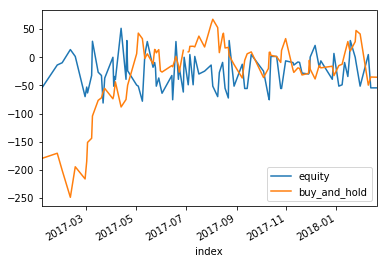

In [262]:
data_backtest_ed = getBacktestResults(data_position_ed,shares=shares)

data_backtest_ed[['equity','buy_and_hold']].plot()

In [241]:
data_backtest_ed.head(10)

,symbol,open,high,low,close,volume,prediction,position,returns,buy_and_hold,pnl,equity
index,,,,,,,,,,,,
2017-06-29,BBVA.MC,7.513,7.610,7.385,7.3107,30285954.0,0,0,0.6187,NaN,0.0000,0.0000
2017-04-03,BBVA.MC,7.146,7.162,6.935,6.8613,38870467.0,0,0,-0.0820,-73.7016,-0.0000,0.0000
2018-01-24,BBVA.MC,7.478,7.533,7.455,7.4800,14458879.0,0,0,-1.3112,27.7652,-0.0000,0.0000
2018-01-17,BBVA.MC,7.400,7.457,7.331,7.3980,21261370.0,0,0,1.0602,14.3172,0.0000,0.0000
2017-01-31,BBVA.MC,6.324,6.440,6.271,6.0868,25278830.0,1,164,0.5233,-200.7196,85.8212,85.8212
2017-11-10,BBVA.MC,7.176,7.228,7.132,7.1470,23208291.0,1,164,-0.5333,-26.8468,-87.4612,-1.6400
2017-08-01,BBVA.MC,7.800,7.810,7.680,7.6703,19199004.0,0,0,0.2360,58.9744,0.0000,-1.6400
2017-11-28,BBVA.MC,7.096,7.141,7.080,7.1370,14642446.0,1,164,0.1669,-28.4868,27.3716,25.7316
2017-07-05,BBVA.MC,7.459,7.570,7.438,7.3730,23387740.0,0,0,-0.4485,10.2172,-0.0000,25.7316


In [191]:
print 'Final Equity at %s is %.3f  => %.3f percent in backtest'%(data_backtest_ed.index[-2],data_backtest_ed['equity'][-1],(data_backtest_ed['equity'][-1]/CAPITAL)*100 )

Final Equity at 2018-02-16 00:00:00 is 2.426  => 0.243 percent in backtest


### Vectorized Backtest

In [235]:
data_position_vector = backtest_vectorized(data_test,shares=shares,lookback_bars=LOOKBACK_BARS)
data_position_vector.head(15)

C:\Users\XE61374\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


backtest_vectorized took 0 seconds


,symbol,open,high,low,close,volume,prediction,position
index,,,,,,,,
2017-06-29,BBVA.MC,7.513,7.610,7.385,7.3107,30285954.0,0,0
2017-04-03,BBVA.MC,7.146,7.162,6.935,6.8613,38870467.0,0,0
2018-01-24,BBVA.MC,7.478,7.533,7.455,7.4800,14458879.0,0,0
2018-01-17,BBVA.MC,7.400,7.457,7.331,7.3980,21261370.0,0,0
2017-01-31,BBVA.MC,6.324,6.440,6.271,6.0868,25278830.0,1,164
2017-11-10,BBVA.MC,7.176,7.228,7.132,7.1470,23208291.0,1,164
2017-08-01,BBVA.MC,7.800,7.810,7.680,7.6703,19199004.0,0,0
2017-11-28,BBVA.MC,7.096,7.141,7.080,7.1370,14642446.0,1,164
2017-07-05,BBVA.MC,7.459,7.570,7.438,7.3730,23387740.0,0,0


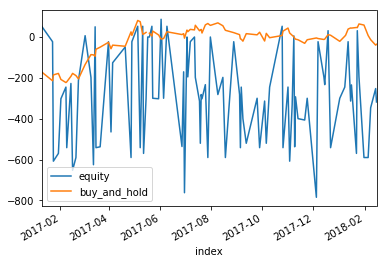

In [229]:
data_backtest_vectorized = getBacktestResults(data_position_vector,shares=shares)

data_backtest_vectorized[['equity','buy_and_hold']].plot()

In [ ]:
data_backtest_vectorized.head(10)

In [190]:
print 'Final Equity at %s is %.3f  => %.3f percent in backtest'%(data_backtest_vectorized.index[-2],data_backtest_vectorized['equity'][-1],(data_backtest_vectorized['equity'][-1]/CAPITAL)*100 )

Final Equity at 2018-02-16 00:00:00 is 397.831  => 39.783 percent in backtest
